# IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import email
import string
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(49)

# LOADING DATA

In [2]:
easy_ham_path = '/kaggle/input/spamassassin-public-corpus/easy_ham/easy_ham/'
hard_ham_path = '/kaggle/input/spamassassin-public-corpus/hard_ham/hard_ham/'
spam_path = '/kaggle/input/spamassassin-public-corpus/spam_2/spam_2/'

In [3]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [4]:
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)

In [5]:
np.random.shuffle(ham)
np.random.shuffle(spam)

In [6]:
print(spam[49]) # take a look to the structure of our data

From msathene@netvigator.com  Mon Jun 24 17:05:41 2002
Return-Path: msathene@netvigator.com
Delivery-Date: Tue May 21 17:12:03 2002
Received: from mandark.labs.netnoteinc.com ([213.105.180.140]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4LGAOe17131 for
    <jm@jmason.org>; Tue, 21 May 2002 17:10:24 +0100
Received: from yc165 ([211.90.196.131]) by mandark.labs.netnoteinc.com
    (8.11.2/8.11.2) with ESMTP id g4LGAKD26779 for <jm@netnoteinc.com>;
    Tue, 21 May 2002 17:10:22 +0100
Received: from netvigator.com [212.45.15.57] by yc165 with ESMTP
    (SMTPD32-7.05 EVAL) id A337188010E; Fri, 17 May 2002 07:39:35 +0800
Message-Id: <000015cf5137$00001045$0000096b@netvigator.com>
To: <yyyy@preserveapts.net>
Cc: <yyyy@po.holsths.dk>, <yyyy@plantnet.com>, <yyyy@ott.net>, <yyyy@neont.com>,
    <jm@netcom20.netcom.com>, <jm@photojm.com>, <jm@paradigmpro.com>,
    <jm@pacbell.net>, <jm@nwi.net>, <jm@nh.conex.net>, <jm@pond.net>,
    <jm@nigro.net>, <jm@net1plus.com>, <jm@pi.net>, <

# DATA PREPREPROCESSING

In [7]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class email_to_clean_text(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))

                    # skip any text/plain (txt) attachments
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)  # get body of email
                        break
            # not multipart - i.e. plain text, no attachments, keeping fingers crossed
            else:
                body = b.get_payload(decode=True) # get body of email
            #####################################################
            soup = BeautifulSoup(body, "html.parser") #get text from body (HTML/text)
            text = soup.get_text().lower()
            #####################################################
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #remove links
            ####################################################
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE) #remove email addresses
            ####################################################
            text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
            ####################################################
            text = ''.join([i for i in text if not i.isdigit()]) # remove digits
            ####################################################
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words] # remove stop words
            ####################################################
            words_list = [lemmatizer.lemmatize(w) for w in words_list] #lemmatization
            ####################################################
            words_list = [stemmer.stem(w) for w in words_list] #Stemming
            text_list.append(' '.join(words_list))
        return text_list

In [8]:
email_to_text = email_to_clean_text()

In [9]:
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

In [10]:
# for Visualization
text_easy_ham = email_to_text.transform(easy_ham)
text_hard_ham = email_to_text.transform(hard_ham)

# Data Visualization

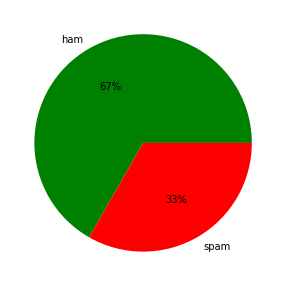

In [11]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['green', 'red']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()


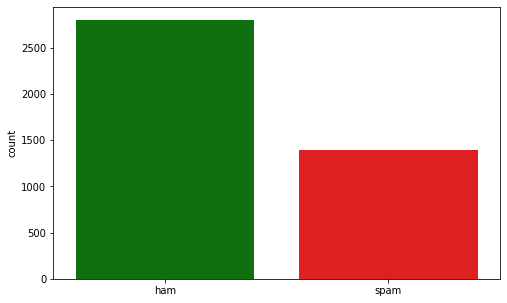

In [12]:
plt.figure(figsize=(8, 5))
sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam), palette=colors)
plt.show()

In [13]:
def plot_WordCloud(text_list):
    unique_string=(" ").join(text_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

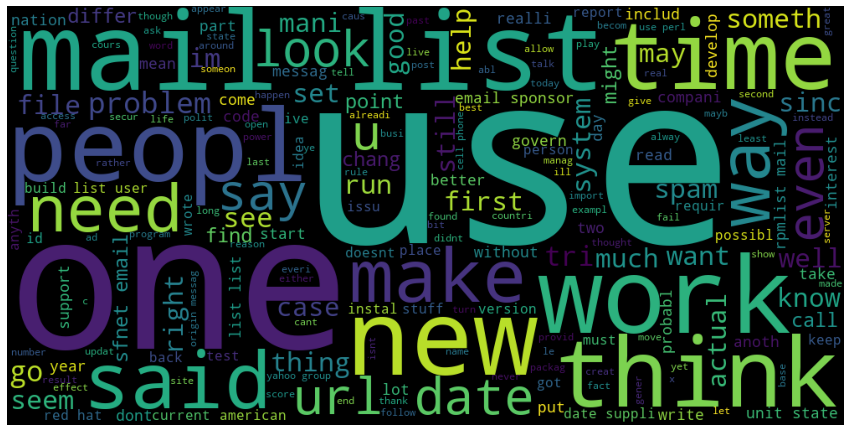

In [14]:
plot_WordCloud(text_easy_ham)

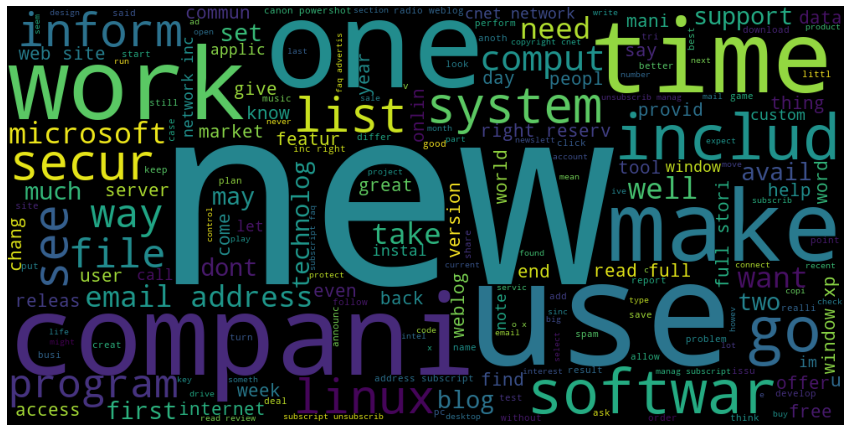

In [15]:
plot_WordCloud(text_hard_ham)

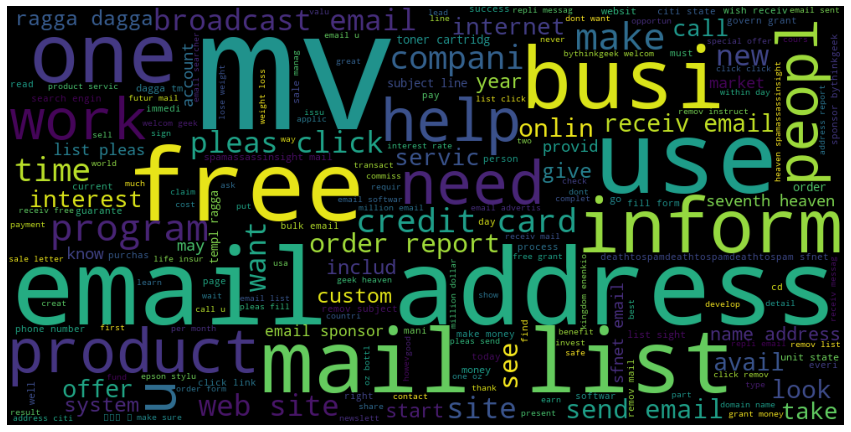

In [16]:
plot_WordCloud(text_spam)

# Splitting dataset

In [17]:
y = len(text_ham)*[0] + len(text_spam)*[1]

**ham : 0**

**spam : 1**

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_ham+text_spam, y,
                                                    stratify=y, 
                                                    test_size=0.2)


# VECTORIZATION

In [19]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)

CountVectorizer(stop_words='english')

In [20]:
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [21]:
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

# MODEL BUILDING

In [22]:
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1200)

In [23]:
predictions = rfc.predict(X_test)

# Model Evaluation

In [24]:
print("accuracy score = {}%".format(round(accuracy_score(y_test, predictions)*100, 2)))
print("f1 score = {}".format(round(f1_score(y_test, predictions), 2)))

accuracy score = 97.74%
f1 score = 0.97


In [25]:
conf_mx = confusion_matrix(y_test, predictions)

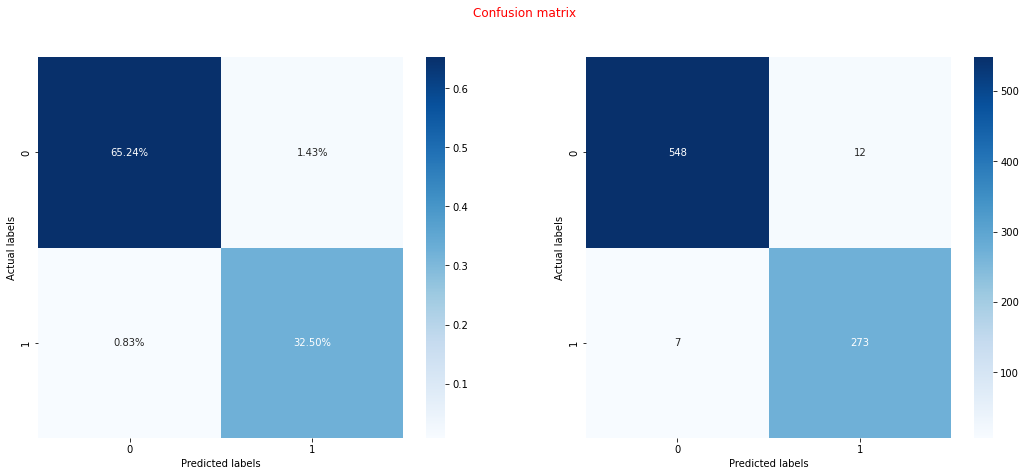

In [26]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

In [27]:
y_scores = cross_val_predict(rfc, X = X_train, y = y_train.reshape((1, len(y_train)))[0], cv=5, 
                             method="predict_proba")

In [28]:
 precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

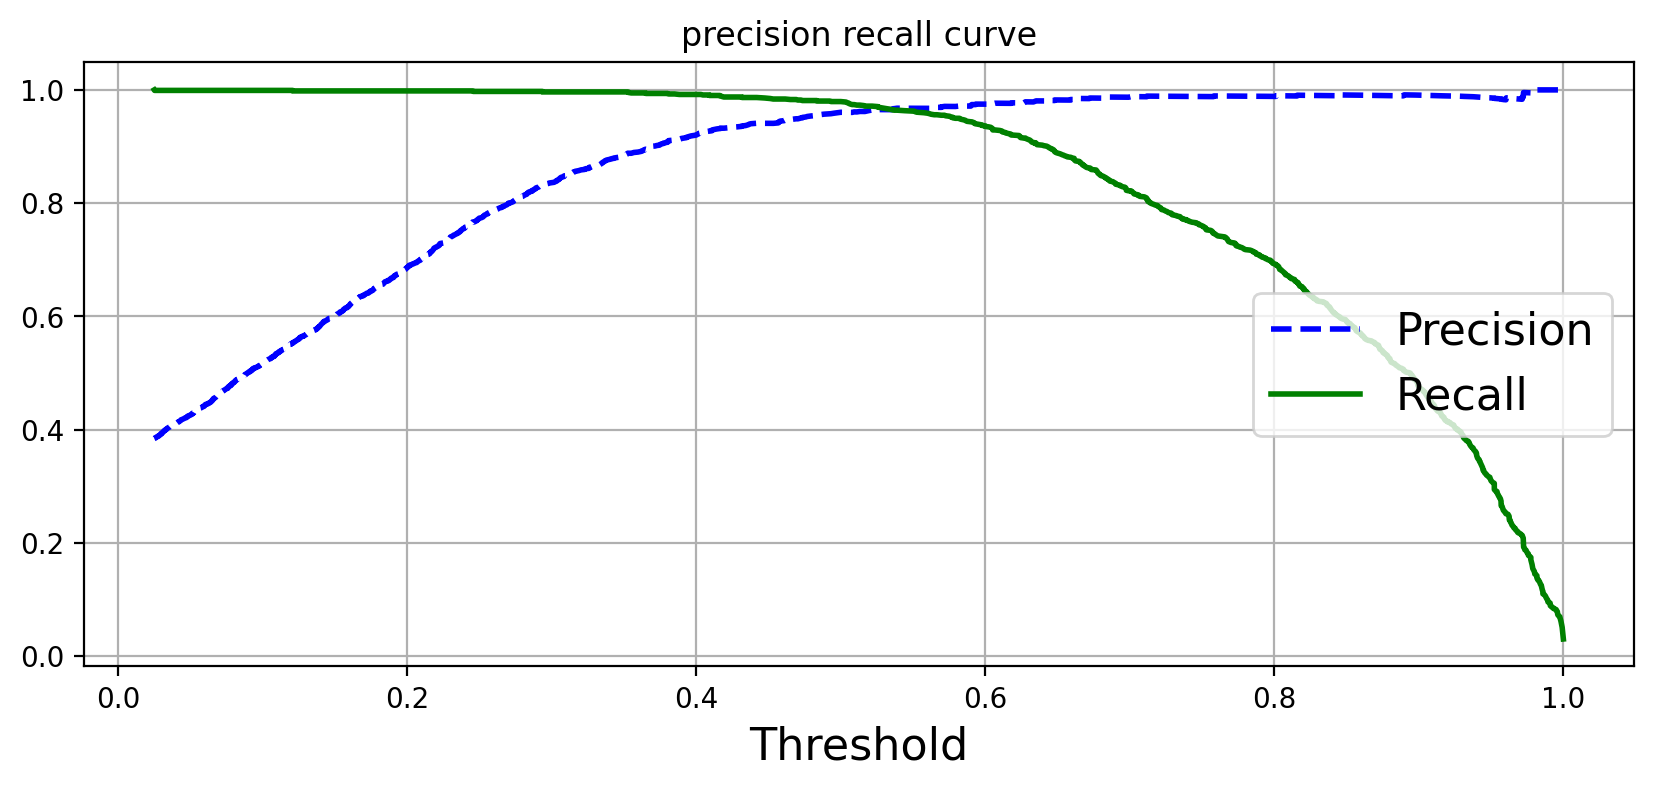

In [29]:
plt.figure(figsize=(10,4), dpi=200)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16) # Not shown in the book
plt.xlabel("Threshold", fontsize=16)        # Not shown
plt.grid(True) 
plt.title("precision recall curve")
plt.show()

In [30]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:,1])
roc_auc_score(y_train, y_scores[:,1])

0.9946925871195914

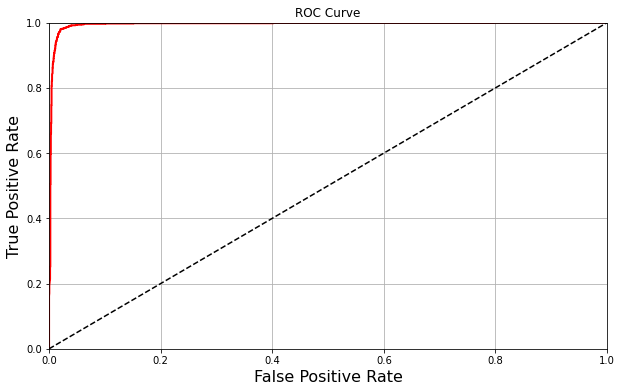

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.grid(True)
plt.title("ROC Curve")
plt.show()

# Data Pipeline

In [32]:
my_pipeline = Pipeline(steps=[
    ('text', email_to_clean_text()),
    ('vector', vectorizer),
    ('model', rfc)])

In [33]:
y1 = np.array(len(ham)*[0]+len(spam)*[1]).reshape(len(ham+spam), 1)

In [34]:
y1

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [35]:
my_pipeline.fit(ham+spam, y1)


Pipeline(steps=[('text', email_to_clean_text()),
                ('vector', CountVectorizer(stop_words='english')),
                ('model', RandomForestClassifier(n_estimators=1200))])

**ham : 0**

**spam : 1**

In [36]:
my_pipeline.predict([hard_ham[77]])

array([0])